In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, random_split
from torch import nn
import pickle
import torch.optim as optim
import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import joblib

In [10]:
# === Загружаем датасеты ===
koi = pd.read_csv("/content/kepler_data.csv", sep=",", on_bad_lines="skip")
k2 = pd.read_csv("/content/k2_data.csv", sep=",", on_bad_lines="skip")
tess = pd.read_csv("/content/tess_data.csv", sep=",", on_bad_lines="skip")

# === KOI ===
koi_df = koi[["koi_period", "koi_duration", "koi_depth", "koi_kepmag", "koi_disposition"]].copy()
koi_df.rename(columns={
    "koi_period": "period",
    "koi_duration": "duration",
    "koi_depth": "depth",
    "koi_kepmag": "mag",
    "koi_disposition": "disposition"
}, inplace=True)

# === K2 ===
k2_df = k2[["pl_orbper", "sy_vmag", "disposition"]].copy()
k2_df.rename(columns={
    "pl_orbper": "period",
    "sy_vmag": "mag"
}, inplace=True)

# Добавляем пустые столбцы для совместимости
k2_df["duration"] = pd.NA
k2_df["depth"] = pd.NA

# === TESS ===
tess_df = tess[["pl_orbper", "pl_trandurh", "pl_trandep", "st_tmag", "tfopwg_disp"]].copy()
tess_df.rename(columns={
    "pl_orbper": "period",
    "pl_trandurh": "duration",
    "pl_trandep": "depth",
    "st_tmag": "mag",
    "tfopwg_disp": "disposition"
}, inplace=True)

# === Объединяем ===
all_data = pd.concat([koi_df, k2_df, tess_df], ignore_index=True)

# === Создаём target ===
all_data["target"] = all_data["disposition"].apply(lambda x: 1 if str(x).upper() == "CONFIRMED" else 0)

# === Балансируем 50/50 ===
confirmed = all_data[all_data["target"] == 1]
other = all_data[all_data["target"] == 0]

min_count = min(len(confirmed), len(other))

balanced = pd.concat([
    confirmed.sample(min_count, random_state=42),
    other.sample(min_count, random_state=42)
], ignore_index=True)

# === Признаки ===
features = ["period", "duration", "depth", "mag"]

# Приводим признаки к числовому типу
for col in features:
    balanced[col] = pd.to_numeric(balanced[col], errors="coerce")

# Убираем строки с NaN после конверсии
balanced = balanced.dropna(subset=features)

X = balanced[features]
y = balanced["target"]

# === MinMaxScaler ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "scaler_noob.pkl")

# === Train/Test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Class balance train:", y_train.value_counts(normalize=True))
print("Class balance test:", y_test.value_counts(normalize=True))


Train size: (5609, 4)  Test size: (1403, 4)
Class balance train: target
0    0.608665
1    0.391335
Name: proportion, dtype: float64
Class balance test: target
0    0.608696
1    0.391304
Name: proportion, dtype: float64


/tmp/ipython-input-851630395.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([koi_df, k2_df, tess_df], ignore_index=True)


In [ ]:
def count_classes(df, name, col):
    confirmed = df[df[col].str.upper() == "CONFIRMED"].shape[0]
    total = df.shape[0]
    other = total - confirmed
    print(f"{name}: CONFIRMED = {confirmed}, OTHER = {other}, TOTAL = {total}")

count_classes(koi, "Kepler", "koi_disposition")
count_classes(k2, "K2", "disposition")
count_classes(tess, "TESS", "tfopwg_disp")

Kepler: CONFIRMED = 2746, OTHER = 6818, TOTAL = 9564
K2: CONFIRMED = 2196, OTHER = 1695, TOTAL = 3891
TESS: CONFIRMED = 0, OTHER = 7668, TOTAL = 7668


In [ ]:
subset = all_data.iloc[100:200]
subset.to_csv("slice_data.csv", index=False, sep=",")

In [11]:
print(all_data.iloc[589])

period          2.896005
duration          1.6776
depth              614.1
mag               15.801
disposition    CONFIRMED
target                 1
Name: 589, dtype: object


In [ ]:
xgb_noob_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=2.35,
    use_label_encode=False
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:48:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encode" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8667
F1 Score: 0.837
ROC-AUC: 0.9328

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89       854
           1       0.80      0.87      0.84       549

    accuracy                           0.87      1403
   macro avg       0.86      0.87      0.86      1403
weighted avg       0.87      0.87      0.87      1403



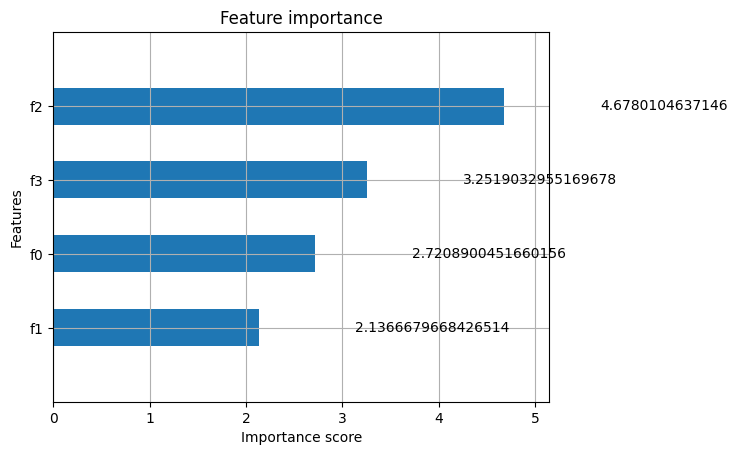

In [ ]:
xgb_noob_model.fit(X_train, y_train)

y_pred = xgb_noob_model.predict(X_test)
y_pred_proba = xgb_noob_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", round(acc, 4))
print("F1 Score:", round(f1, 4))
print("ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Важность признаков
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_noob_model, importance_type="gain", max_num_features=15, height=0.5)
plt.show()

In [4]:
# === Загружаем датасеты ===
koi = pd.read_csv("/content/kepler_data.csv", sep=",", on_bad_lines="skip")
k2 = pd.read_csv("/content/k2_data.csv", sep=",", on_bad_lines="skip")
tess = pd.read_csv("/content/tess_data.csv", sep=",", on_bad_lines="skip")

# === KOI ===
koi_df = koi[["koi_period", "koi_duration", "koi_depth", "koi_prad", "koi_steff", "koi_srad", "koi_kepmag", "koi_disposition"]].copy()
koi_df.rename(columns={
    "koi_period": "period",
    "koi_duration": "duration",
    "koi_depth": "depth",
    "koi_prad": "prad",
    "koi_steff": "steff",
    "koi_srad": "srad",
    "koi_kepmag": "mag",
    "koi_disposition": "disposition"
}, inplace=True)

# === K2 ===
k2_df = k2[["pl_orbper", "pl_rade", "st_teff", "st_rad", "sy_vmag", "disposition"]].copy()
k2_df.rename(columns={
    "pl_orbper": "period",
    "pl_rade": "prad",
    "st_teff": "steff",
    "st_rad": "srad",
    "sy_vmag": "mag"
}, inplace=True)

# Добавляем пустые столбцы для совместимости
k2_df["duration"] = pd.NA
k2_df["depth"] = pd.NA

# === TESS ===
tess_df = tess[["pl_orbper", "pl_trandurh", "pl_trandep", "pl_rade", "st_teff", "st_rad", "st_tmag", "tfopwg_disp"]].copy()
tess_df.rename(columns={
    "pl_orbper": "period",
    "pl_trandurh": "duration",
    "pl_trandep": "depth",
    "pl_rade": "prad",
    "st_teff": "steff",
    "st_rad": "srad",
    "st_tmag": "mag",
    "tfopwg_disp": "disposition"
}, inplace=True)

# === Объединяем ===
all_data = pd.concat([koi_df, k2_df, tess_df], ignore_index=True)

# === Создаём target ===
all_data["target"] = all_data["disposition"].apply(lambda x: 1 if str(x).upper() == "CONFIRMED" else 0)

# === Балансируем 50/50 ===
confirmed = all_data[all_data["target"] == 1]
other = all_data[all_data["target"] == 0]

min_count = min(len(confirmed), len(other))

balanced = pd.concat([
    confirmed.sample(min_count, random_state=42),
    other.sample(min_count, random_state=42)
], ignore_index=True)

# === Признаки ===
features = ["period", "duration", "depth", "prad", "steff", "srad", "mag"]

# Приводим признаки к числовому типу
for col in features:
    balanced[col] = pd.to_numeric(balanced[col], errors="coerce")

# Убираем строки с NaN после конверсии
balanced = balanced.dropna(subset=features)

X = balanced[features]
y = balanced["target"]

# === MinMaxScaler ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "scaler_pro.pkl")

# === Train/Test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Class balance train:", y_train.value_counts(normalize=True))
print("Class balance test:", y_test.value_counts(normalize=True))

Train size: (5486, 7)  Test size: (1372, 7)
Class balance train: target
0    0.599891
1    0.400109
Name: proportion, dtype: float64
Class balance test: target
0    0.599854
1    0.400146
Name: proportion, dtype: float64


/tmp/ipython-input-2850606817.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([koi_df, k2_df, tess_df], ignore_index=True)


In [ ]:
subset = all_data.iloc[100:200]
subset.to_csv("slice_data_pro.csv", index=False, sep=",")

In [7]:
print(all_data.iloc[1356])

period         11.720124
duration          3.0039
depth             9763.3
prad                7.94
steff             5215.0
srad                0.77
mag               14.518
disposition    CONFIRMED
target                 1
Name: 1356, dtype: object


In [ ]:
xgb_pro_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=2.35,
    use_label_encode=False
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:51:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encode" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9031
F1 Score: 0.8836
ROC-AUC: 0.9487

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       823
           1       0.85      0.92      0.88       549

    accuracy                           0.90      1372
   macro avg       0.90      0.91      0.90      1372
weighted avg       0.91      0.90      0.90      1372



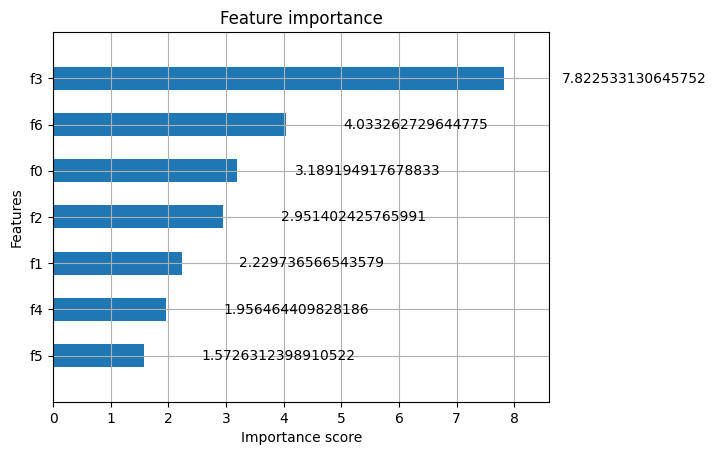

In [ ]:
xgb_pro_model.fit(X_train, y_train)

y_pred = xgb_pro_model.predict(X_test)
y_pred_proba = xgb_pro_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", round(acc, 4))
print("F1 Score:", round(f1, 4))
print("ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Важность признаков
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_pro_model, importance_type="gain", max_num_features=15, height=0.5)
plt.show()